# Brain MRI Segmentation

This notebook contains a simplistic code for barin MRI segmentation task. 
[The dataset](https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation) that is used here contains only 110 patients and is obtained from The Cancer Genome Atlas (TCGA).
Also, some parts of this code are building on top of [this notebook](https://www.kaggle.com/mateuszbuda/brain-segmentation-pytorch).

In [11]:
import os
import logging
import numpy as np
import imgaug.augmenters as iaa
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import Compose

from datasets.brain_dataset import BrainSegmentationDataset
from datasets.transforms import Augmentation, ToTensor, ToImage
from models.unet import UNet
from metrics.dice_loss import DiceLoss, dice_score
from train import train_supervised, train_eval_supervised, train_semi_supervised, train_eval_semi_supervised
from evaluate import evaluate, generate_outputs
from utils.params import Params, save_dict_to_json
from utils.logger import set_logger, save_checkpoint, load_checkpoint
from utils.visualizer import save_image_mask, plot_samples

In [12]:
dataset_dir = "/pasteur/u/mottaghi/lgg-mri-segmentation/processed"
params_path = "experiments/base_params.json"
model_dir = "experiments/semi-supervised_run2"
restore = True
os.makedirs(model_dir, exist_ok=True)

params = Params(params_path)
params.save(os.path.join(model_dir, "params.json"))
params.model_dir = model_dir
params.restore = True
params.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
set_logger(os.path.join(model_dir, "logs.txt"))

In [13]:
week_aug = iaa.Sequential([
    iaa.Affine(scale=(0.95, 1.05)), 
    iaa.Affine(rotate=(-15, 15)),
    iaa.Fliplr(0.5), 
])
strong_aug = iaa.Sequential([
    iaa.Affine(scale=(0.8, 1.2)), 
    iaa.Affine(rotate=(-30, 30)),
    iaa.Fliplr(0.5), 
])
week_transforms = Compose([Augmentation(week_aug), ToTensor()])
strong_transforms = Compose([Augmentation(strong_aug), ToTensor()])
params.strong_transforms = strong_transforms
totensor = ToTensor()
toimage = ToImage()

### Data

In [14]:
labeled_dataset = BrainSegmentationDataset(dataset_dir, subset="labeled", transform=week_transforms, params=params)
unlabeled_dataset = BrainSegmentationDataset(dataset_dir, subset="unlabeled", transform=totensor, params=params)
val_dataset = BrainSegmentationDataset(dataset_dir, subset="validation", transform=totensor, params=params)

In [15]:
labeled_loader = DataLoader(labeled_dataset, batch_size=params.batch_size, shuffle=True, drop_last=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=params.mu*params.batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=params.batch_size, drop_last=False)

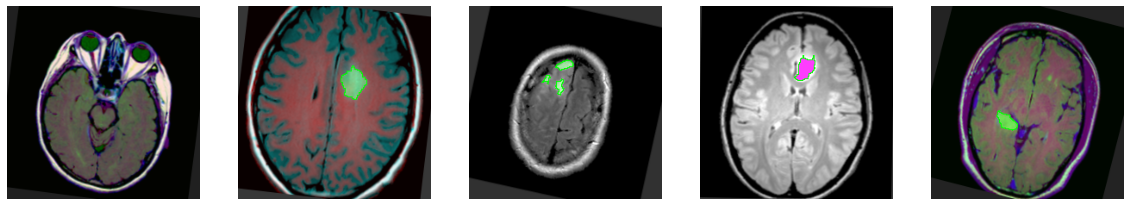

In [16]:
rand_idx = np.random.choice(len(labeled_dataset), 5)
samples = [toimage(labeled_dataset[idx]) for idx in rand_idx]
plot_samples(samples)

### Training

In [17]:
model = UNet(in_channels=3, out_channels=1)
model.to(params.device)
optimizer = torch.optim.Adam(model.parameters(), lr=params.learning_rate)
loss_fn = DiceLoss()
metrics = {'dice score': dice_score}

In [18]:
train_eval_semi_supervised(model, optimizer, loss_fn, labeled_loader, unlabeled_loader, val_loader, metrics, params)

Restoring parameters from experiments/semi-supervised_run2/best.pth.tar
Epoch 120/200
100%|██████████| 24/24 [00:08<00:00,  2.83it/s, loss=0.236]
- Train metrics: dice score: 0.935 ; labeled loss: 0.118 ; unlabeled loss: 0.000
- Eval metrics : dice score: 0.686 ; loss: 0.436
Epoch 121/200
100%|██████████| 24/24 [00:08<00:00,  2.82it/s, loss=0.250]
- Train metrics: dice score: 0.927 ; labeled loss: 0.140 ; unlabeled loss: 0.103
- Eval metrics : dice score: 0.747 ; loss: 0.393
Epoch 122/200
100%|██████████| 24/24 [00:08<00:00,  2.89it/s, loss=0.236]
- Train metrics: dice score: 0.902 ; labeled loss: 0.131 ; unlabeled loss: 0.027
- Eval metrics : dice score: 0.695 ; loss: 0.472
Epoch 123/200
100%|██████████| 24/24 [00:08<00:00,  2.83it/s, loss=0.241]
- Train metrics: dice score: 0.882 ; labeled loss: 0.135 ; unlabeled loss: 0.158
- Eval metrics : dice score: 0.666 ; loss: 0.418
Epoch 124/200
100%|██████████| 24/24 [00:08<00:00,  2.77it/s, loss=0.218]
- Train metrics: dice score: 0.837 ; l

### Evaluation

In [22]:
output_list = generate_outputs(model, val_loader, params, save=True)

/sailhome/mottaghi/brain-segmentation/utils/visualizer.py:33: UserWarning: experiments/semi-supervised_run2/output/val_155.png is a low contrast image
  imsave(path, image)
/sailhome/mottaghi/brain-segmentation/utils/visualizer.py:33: UserWarning: experiments/semi-supervised_run2/output/val_207.png is a low contrast image
  imsave(path, image)
/sailhome/mottaghi/brain-segmentation/utils/visualizer.py:33: UserWarning: experiments/semi-supervised_run2/output/val_208.png is a low contrast image
  imsave(path, image)
/sailhome/mottaghi/brain-segmentation/utils/visualizer.py:33: UserWarning: experiments/semi-supervised_run2/output/val_209.png is a low contrast image
  imsave(path, image)
/sailhome/mottaghi/brain-segmentation/utils/visualizer.py:33: UserWarning: experiments/semi-supervised_run2/output/val_260.png is a low contrast image
  imsave(path, image)
/sailhome/mottaghi/brain-segmentation/utils/visualizer.py:33: UserWarning: experiments/semi-supervised_run2/output/val_295.png is a low

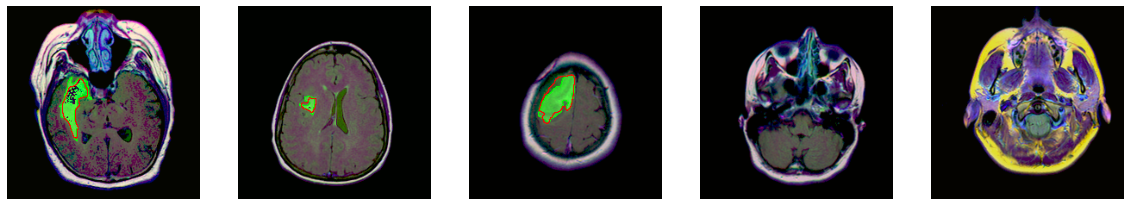

In [30]:
rand_idx = np.random.choice(len(output_list), 5)
samples = [output_list[idx] for idx in rand_idx]
plot_samples(samples)